In [ ]:
# Class names of Pascal voc dataset

class_names = ['__background__', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']

In [ ]:
# Loading modules

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from PIL import Image
import matplotlib.pyplot as plt
import time
import os
import cv2
import copy
import glob
!pip install torchmetrics
from torchmetrics import ConfusionMatrix
cudnn.benchmark = True
plt.ion()   # interactive mode

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# define the torchvision image transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [ ]:
num_classes = len(class_names)
num_classes

21

In [ ]:
def get_segment_labels(image, model, device):
    image = transform(image).to(device)
    image = image.unsqueeze(0) # add a batch dimension
    outputs = model(image)
    return outputs

In [ ]:
def draw_segmentation_map(outputs):
    labels = torch.argmax(outputs.squeeze(), dim=0).detach().cpu().numpy()
    red_map = np.zeros_like(labels).astype(np.uint8)
    green_map = np.zeros_like(labels).astype(np.uint8)
    blue_map = np.zeros_like(labels).astype(np.uint8)
    
    for label_num in range(0, len(label_map)):
        index = labels == label_num
        red_map[index] = np.array(label_map)[label_num, 2]
        green_map[index] = np.array(label_map)[label_num, 1]
        blue_map[index] = np.array(label_map)[label_num, 0]
        
    segmented_image = np.stack([red_map, green_map, blue_map], axis=2)
    return segmented_image

In [ ]:
# download or load the model from disk
model = torchvision.models.segmentation.fcn_resnet50(pretrained=True)

# set computation device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model to eval() model and load onto computation devicce
model.eval().to(device)

In [ ]:
confmat = ConfusionMatrix(task="multiclass", num_classes=num_classes)

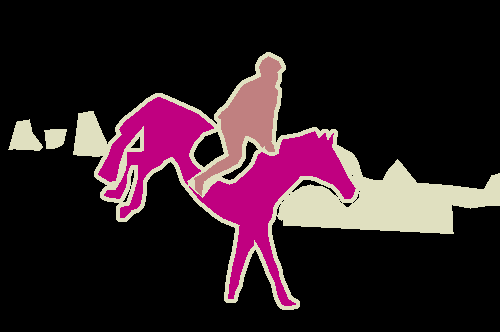

In [ ]:
# View the labels imag

from google.colab.patches import cv2_imshow
mask = cv2.imread('/content/drive/MyDrive/AIP/Assignment_2/PascalVOC/test/Annotations/000392.png')
cv2_imshow(mask)

In [ ]:
# Color maps 

def color_map(N=256, normalized=False):
    def bitget(byteval, idx):
        return ((byteval & (1 << idx)) != 0)

    dtype = 'float32' if normalized else 'uint8'
    cmap = np.zeros((N, 3), dtype=dtype)
    for i in range(N):
        r = g = b = 0
        c = i
        for j in range(8):
            r = r | (bitget(c, 0) << 7-j)
            g = g | (bitget(c, 1) << 7-j)
            b = b | (bitget(c, 2) << 7-j)
            c = c >> 3

        cmap[i] = np.array([r, g, b])

    cmap = cmap/255 if normalized else cmap
    return cmap
label_map = color_map(21)
label_map

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0],
       [  0,  64, 128]], dtype=uint8)

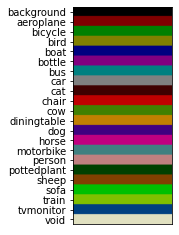

In [ ]:
def color_map_viz():
    labels = ['background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor', 'void']
    nclasses = 21
    row_size = 50
    col_size = 500
    cmap = color_map()
    array = np.empty((row_size*(nclasses+1), col_size, cmap.shape[1]), dtype=cmap.dtype)
    for i in range(nclasses):
        array[i*row_size:i*row_size+row_size, :] = cmap[i]
    array[nclasses*row_size:nclasses*row_size+row_size, :] = cmap[-1]

    plt.imshow(array)
    plt.yticks([row_size*i+row_size/2 for i in range(nclasses+1)], labels)
    plt.xticks([])
    plt.show()
color_map_viz()

In [ ]:
def colormap2label():
    colormap2label = torch.zeros(256 ** 3, dtype=torch.long)
    for i, colormap in enumerate(label_map):
        colormap2label[
            (colormap[0] * 256 + colormap[1]) * 256 + colormap[2]] = i
    return colormap2label

    
def voc_label_indices(colormap, colormap2label):
    colormap = colormap.permute(1, 2, 0).numpy().astype('int32')
    idx = ((colormap[:, :, 0] * 256 + colormap[:, :, 1]) * 256
           + colormap[:, :, 2])
    return colormap2label[idx]
c2l = colormap2label()

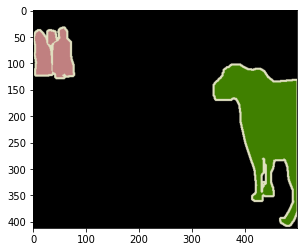

In [ ]:
path = '/content/drive/MyDrive/AIP/Assignment_2/PascalVOC/test/Annotations/000504.png'
mode = torchvision.io.image.ImageReadMode.RGB
mask = torchvision.io.read_image(path,mode)
plt.imshow(mask.permute(1,2,0))

In [ ]:
# return pixel_wise accuracy and mean IOU

def accuracy(target,pred):
  confmat = ConfusionMatrix(task="multiclass", num_classes=num_classes)
  mat = confmat(pred, target)
  #print(mat)
  pixel_acc = torch.trace(mat).item()/torch.sum(mat).item()
  iou = 0

  count = 0
  for i in range(21):
    intersection = mat[i,i]
    union = sum(mat[i,:])+sum(mat[:,i])-mat[i,i]
    if union==0:
      continue
    count+=1
    iou+=intersection/union

  iou/=count

  return pixel_acc,iou

In [ ]:
# passing single image

def segmented(img_path):
  #img = cv2.imread(img_path)
  img = Image.open(img_path)
  img = img.convert("RGB")
  output = get_segment_labels(img,model,'cpu')
  return draw_segmentation_map(output['out'])
img_path = '/content/drive/MyDrive/AIP/Assignment_2/PascalVOC/test/Images/000068.jpg'
seg = segmented(img_path)
mask = cv2.imread('/content/drive/MyDrive/AIP/Assignment_2/PascalVOC/test/Annotations/000068.png')

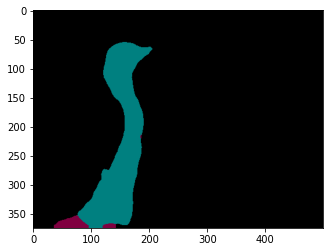

In [ ]:
plt.imshow(seg)

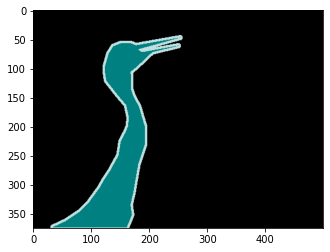

In [ ]:
plt.imshow(mask)

In [ ]:
# Getting the predicted annotations of test dataset

folder_path = '/content/drive/MyDrive/AIP/Assignment_2/PascalVOC/test'
mask_paths = glob.glob(os.path.join(folder_path,'Annotations','*.png'))
mode = torchvision.io.image.ImageReadMode.RGB

p_a = []
iou = []
for mask_path in mask_paths:
  img_path = os.path.join(folder_path,'Images',os.path.basename(mask_path).replace('png','jpg'))
  mask = torchvision.io.read_image(mask_path,mode)
  img = Image.open(img_path)
  img = img.convert("RGB")

  output = get_segment_labels(img,model,'cpu')
  labels = torch.argmax(output['out'].squeeze(), dim=0).detach()
  
  y = voc_label_indices(mask, colormap2label())
  #print(y.shape,labels.shape)
  pix_acc,miou = accuracy(y,labels)
  print(pix_acc,miou)
  p_a.append(pix_acc)
  iou.append(miou)


0.7049973333333334 tensor(0.1777)
0.9533933933933934 tensor(0.7056)
0.9749973333333334 tensor(0.9159)
0.9554773333333333 tensor(0.7051)
0.981696 tensor(0.9365)
0.9775315315315315 tensor(0.6261)
0.8046351084812623 tensor(0.4520)
0.955232 tensor(0.4952)
0.7794550898203593 tensor(0.4678)
0.8946786786786787 tensor(0.4691)
0.9721741741741742 tensor(0.5649)
0.9440586666666667 tensor(0.5935)
0.9653222730739893 tensor(0.8241)
0.9541382833787466 tensor(0.8086)
0.9924106666666667 tensor(0.3503)
0.9764693333333333 tensor(0.9530)
0.9731525157232704 tensor(0.8613)
0.9639578408195429 tensor(0.8044)
0.966512 tensor(0.8923)
0.9769279538904899 tensor(0.8612)
0.990592 tensor(0.9202)
0.9157 tensor(0.5951)
0.9578149466192171 tensor(0.4050)
0.9546744186046512 tensor(0.8880)
0.9494277286135693 tensor(0.9029)
0.9836857142857143 tensor(0.9637)
0.616336231884058 tensor(0.2967)
0.6920540540540541 tensor(0.4116)
0.860784 tensor(0.6317)
0.9721493333333333 tensor(0.6254)
0.8938453333333334 tensor(0.6234)
0.8984684

In [ ]:
import pandas as pd
df = pd.DataFrame(list(zip(p_a, iou)),
               columns =['Pixel_Acc', 'IOU'])
df.to_csv('/content/drive/MyDrive/AIP/Assignment_2/PascalVOC/Resnet_50_stat.csv')

In [ ]:
np.mean(p_a)

0.9163349391005375

In [ ]:
np.mean(iou)

0.64002615